# 0x04 Multilayer Perceptrons

The key difference between generative and discriminative classifiers is how they model the data. 
- **Generative classifiers** models the class conditional and the prior, and computes the posterior.
$$
p(x|C_k), p(C_k) \rightarrow p(C_k | x)
$$
- **Discriminative classifiers** models the posterior directly.
$$
p(C_k | x)
$$

> *"How can a classifier be "generative"?"*

For generative classifier, since we know $p(x|C_k)$, 
(i. e. given a class, we know how the data looks like),

we can generate new data points by sampling from the distribution.

Today, we will be looking at two simplest classifiers from both categories:
- **Discriminative**: Logistic Regression
- **Generative**: Naive Bayes

## 1. Dataset and preprocessing

We will invite our old friend, the Iris dataset.

Iris dataset is a classic classification dataset that contains 3 classes of iris plants (Setosa, Versicolor, Virginica) with 4 features (sepal length, sepal width, petal length, petal width).

The target is to predict the class of the iris plant based on the features.

In [1]:
import pandas as pd

# Import data from the csv file
iris_df = pd.read_csv('data/Iris.csv')

# Display the first few rows of the data
iris_df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


Before we dive into the data analysis part, let's visualize the dataset.

We will pick the first two features (sepal length and sepal width) and plot them in a 2D space.

For the sake of visualization, we will also only use sepal length and sepal width in the following analysis with figures.

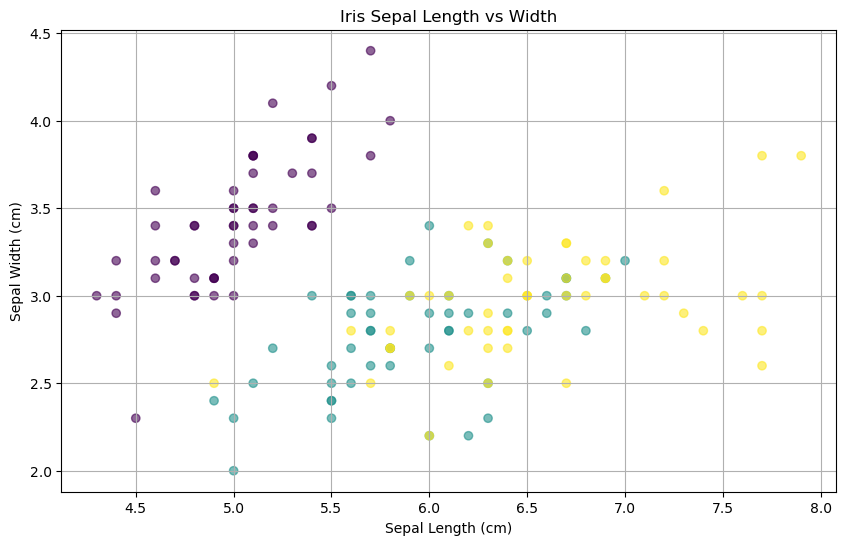

In [2]:
import matplotlib.pyplot as plt

vis_df = iris_df.copy()
vis_df['Species'] = vis_df['Species'].astype('category')

plt.figure(figsize=(10, 6))
plt.scatter(vis_df['SepalLengthCm'], vis_df['SepalWidthCm'], c=vis_df['Species'].cat.codes, cmap='viridis', alpha=0.6)
plt.title('Iris Sepal Length vs Width')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.grid()
plt.show()

## 2. Discriminative classifier: Logistic Regression

Let's start with one of the simplest classifiers, Logistic Regression.
It is used to perform binary classification.

It's formula is given by:
$$
p(y=1|x) = \sigma(w^Tx), \quad
\sigma(z) = \frac{1}{1 + e^{-z}}
$$
where $w$ is the weight vector and $x$ is the feature vector.

> ❗️ Although **NAMED** "regression", it is a classification algorithm!

Let's use scikit-learn to implement Logistic Regression.

In [3]:
from sklearn.linear_model import LogisticRegression
# This can help you split the data into training and testing sets
from sklearn.model_selection import train_test_split
# Generate reports on the performance of the model
from sklearn.metrics import classification_report, confusion_matrix

lr = LogisticRegression(max_iter=200)
# Split the data into training and testing sets
X = iris_df[['SepalLengthCm', 'SepalWidthCm']]
y = iris_df['Species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Fit the model
lr.fit(X_train, y_train)
# Make predictions
y_pred = lr.predict(X_test)
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
# Generate a classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[10  0  0]
 [ 0  7  2]
 [ 0  1 10]]
Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.88      0.78      0.82         9
 Iris-virginica       0.83      0.91      0.87        11

       accuracy                           0.90        30
      macro avg       0.90      0.90      0.90        30
   weighted avg       0.90      0.90      0.90        30



We can now visualize the decision boundary of the Logistic Regression classifier.

This code will not be very straightforward, but we will explain step by step.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Define the range
x_min, x_max = X['SepalLengthCm'].min() - 1, X['SepalLengthCm'].max() + 1
y_min, y_max = X['SepalWidthCm'].min() - 1, X['SepalWidthCm'].max() + 1
# Create a mesh grid. A mesh grid is a grid of points in the feature space
# We will use this set of points to feed into our model to get the predictions
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))


In [5]:
# Create a 2D array of points in the feature space
points = pd.DataFrame(
    {
        'SepalLengthCm': xx.reshape(-1),
        'SepalWidthCm': yy.reshape(-1)
    }   
)

# Make predictions on the mesh grid points
Z = lr.predict(points)
# Reshape the predictions to match the shape of the mesh grid
Z = Z.reshape(xx.shape)

In [6]:
# Z is string, we have to map it to numbers so we can visualize it
mapping_dict = {
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
}
Z = np.vectorize(lambda x: mapping_dict[x])(Z)

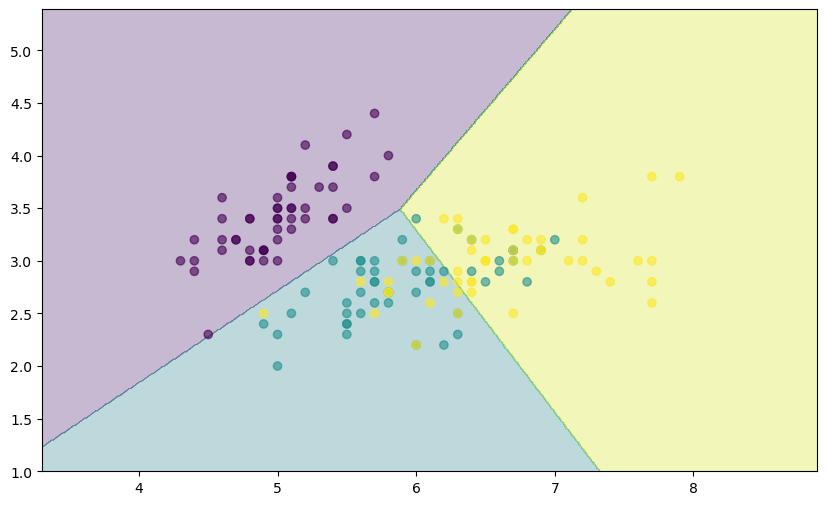

In [7]:
plt.figure(figsize=(10, 6))
# Plot the decision boundary with another color map
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
# Plot the iris dataset
plt.scatter(vis_df['SepalLengthCm'], vis_df['SepalWidthCm'], c=vis_df['Species'].cat.codes, cmap='viridis', alpha=0.6)

You can observe that the decision boundary divides the 2D space into 3 regions.

As we can see, besides giving the decision boundary, the model does not tell us about how the data in each class looks like.
It just provides a decision boundary that **separates** the classes.

Is there any way to also know the distribution of the data in each class?

## 3. Generative classifier: Naive Bayes

Naive Bayes is a generative classifier that is based on Bayes' theorem.
It is called "naive" because it assumes that the features are **conditionally independent** given the class label.

The formula is given by:
$$
p(y|x) = \frac{p(x|y)p(y)}{p(x)}
$$

where the naive assumption is given by
$$
p(x|y) = \prod_{i=1}^n p(x_i|y)
$$
where $x_i$ is the $i$-th feature of the feature vector $x$.

Naive Bayes is generative as it explicitly models the $p(x|y)$,
i.e. given that x belongs to class y, we know how the data looks like.

Let's do a hands-on implementation of Naive Bayes classifier.
We will use the Gaussian Naive Bayes, which assumes that the features are normally distributed.

In [8]:
# Import the necessary libraries
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Fit the model
gnb.fit(X_train, y_train)
# Make predictions
y_pred = gnb.predict(X_test)
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
# Generate a classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[10  0  0]
 [ 0  7  2]
 [ 0  1 10]]
Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.88      0.78      0.82         9
 Iris-virginica       0.83      0.91      0.87        11

       accuracy                           0.90        30
      macro avg       0.90      0.90      0.90        30
   weighted avg       0.90      0.90      0.90        30



Let us see what the decision boundary looks like now.

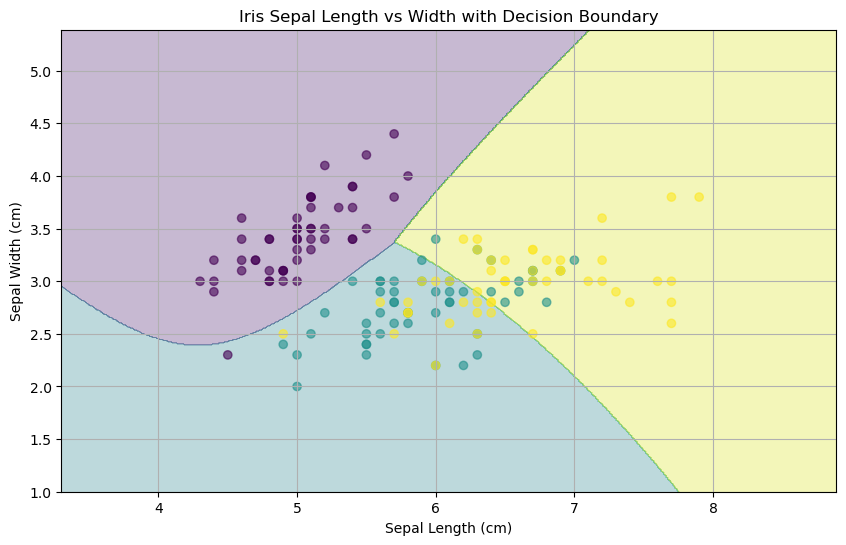

In [9]:
# Create a 2D array of points in the feature space
points = pd.DataFrame(
    {
        'SepalLengthCm': xx.reshape(-1),
        'SepalWidthCm': yy.reshape(-1)
    }   
)
# Make predictions on the mesh grid points
Z = gnb.predict(points)
# Reshape the predictions to match the shape of the mesh grid
Z = Z.reshape(xx.shape)
# Z is string, we have to map it to numbers so we can visualize it
Z = np.vectorize(lambda x: mapping_dict[x])(Z)
plt.figure(figsize=(10, 6))
# Plot the decision boundary with another color map
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
# Plot the iris dataset
plt.scatter(vis_df['SepalLengthCm'], vis_df['SepalWidthCm'], c=vis_df['Species'].cat.codes, cmap='viridis', alpha=0.6)  
plt.title('Iris Sepal Length vs Width with Decision Boundary')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.grid()
plt.show()

> 🤔 **THINKING**
>
> - Why is the decision boundary not linear anymore?

> 📚 **EXERCISE**
>
> We have said that generative classifiers can generate new data points.
>
> Here, we provide you the code to get the $\mu$ and $\sigma$ of each class.
> - Can you generate new data points for each class? (Hint: Use `numpy` for sampling a normal distribution)
> - Can you visualize the generated data points?
> - Compare the generated data points with the original data points. What do you observe?

In [10]:
# Iterate through the classes (species)
gaussian_info = []

for class_idx in range(len(gnb.classes_)):
    name = gnb.classes_[class_idx]
    means = gnb.theta_[class_idx]
    variances = gnb.var_[class_idx]
    gaussian_info.append([name, means, variances])

gaussian_info_df = pd.DataFrame(gaussian_info, columns=['Species', 'Means', 'Variances'])

# The means and variances are np.ndarray objects
gaussian_info_df


,Species,Means,Variances
0,Iris-setosa,"[4.99, 3.44]","[0.12390000067299932, 0.15490000067299928]"
1,Iris-versicolor,"[5.919512195121952, 2.770731707317073]","[0.2869363480852539, 0.10011897747252342]"
2,Iris-virginica,"[6.533333333333333, 2.966666666666667]","[0.4165811972541959, 0.09914529981829844]"


In [11]:
# === Your code here ===